# 5. Further improvements of the prediction

---
**To be able to execute this notebook, please download your own local version of the data from https://www.kaggle.com/martinellis/nhl-game-data and store it into the folder "data/nhl/nhl_stats/".** 

**In addition, please download your own local version of the data from https://www.kaggle.com/camnugent/predict-nhl-player-salaries and store it into the folder "data/nhl/nhl_salaries/"**


---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import math

from matplotlib import pyplot as plt

from utils import create_dummy_df
from lightgbm import LGBMClassifier

from utils import plot_correlation_matrix
from utils import calculate_confusion_matrix
from utils import run_model

sns.set()

---

Putting the dataset together and enriching it by player ids for skater (make a shot) and goalie (keeping the shot). This additional data will be used further in this section:

In [2]:
df_player = pd.read_csv('data/nhl/nhl_stats/game_plays_players.csv')
df_player.drop_duplicates(inplace=True)
df_player.head()

,play_id,game_id,player_id,playerType
0,2016020045_4,2016020045,8473604,Winner
1,2016020045_4,2016020045,8473512,Loser
2,2016020045_5,2016020045,8473573,Shooter
3,2016020045_5,2016020045,8473607,Goalie
4,2016020045_6,2016020045,8474141,Scorer


---
Read and filter the data frame twice, once for skate, once for goalie:

In [3]:
df_skater = df_player[df_player.playerType.isin(['Shooter', 'Scorer'])].copy()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)
df_skater.drop(columns=['game_id', 'playerType'], inplace=True)

df_goalie = df_player[df_player.playerType.isin(['Goalie'])].copy()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)
df_goalie.drop(columns=['game_id', 'playerType'], inplace=True)

---
Merge both player types with game plays:

In [4]:
df_game_plays = pd.read_csv('data/nhl/nhl_stats/game_plays.csv')
df_game_plays.drop_duplicates(inplace=True)

In [5]:
df = df_game_plays.merge(df_skater, how='left', on='play_id')
df = df.merge(df_goalie, how='left', on='play_id')

---
Reduce to relevant events:

In [6]:
df = df[(df.event=='Goal') | (df.event=='Shot')]
df.head()

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y,skater_id,goalie_id
4,2016020045_5,2016020045,16.0,4.0,Shot,Wrist Shot,-71.0,9.0,1,REGULAR,54,1146.0,2016-10-19 01:41:44,0,0,Artem Anisimov Wrist Shot saved by Michal Neuv...,71.0,-9.0,8473573.0,8473607.0
5,2016020045_6,2016020045,16.0,4.0,Goal,Wrap-around,-88.0,5.0,1,REGULAR,56,1144.0,2016-10-19 01:41:48,0,1,"Patrick Kane (1) Wrap-around, assists: Artem A...",88.0,-5.0,8474141.0,8473607.0
7,2016020045_8,2016020045,4.0,16.0,Shot,Wrist Shot,56.0,-7.0,1,REGULAR,69,1131.0,2016-10-19 01:42:41,0,1,Dale Weise Wrist Shot saved by Corey Crawford,56.0,-7.0,8474668.0,8470645.0
11,2016020045_12,2016020045,16.0,4.0,Shot,Slap Shot,-37.0,-24.0,1,REGULAR,133,1067.0,2016-10-19 01:43:45,0,1,Duncan Keith Slap Shot saved by Michal Neuvirth,37.0,24.0,8470281.0,8473607.0
16,2016020045_17,2016020045,4.0,16.0,Shot,Wrist Shot,57.0,-20.0,1,REGULAR,168,1032.0,2016-10-19 01:44:54,0,1,Wayne Simmonds Wrist Shot saved by Corey Crawford,57.0,-20.0,8474190.0,8470645.0


The final DataFrame contains data we used in the previous sections + information regarding the shooting scater and the goalie. These information might be usefull for prediction improvements as the skills of the shooting player and of the goalie might matter.

---

## Preparing data to be used for modelling (dropping nan, resolving categorical features)

Most of these preparations have been already done in previous sections:

In [7]:
df_data = df.copy() #saving df
# select columns, drop nans
df_data = df_data[['play_id', 'event', 'secondaryType', 'st_x', 'st_y', 'period', 'periodTime', 'skater_id', 'goalie_id']]
df_data.dropna(inplace=True)
df_data.secondaryType = df_data.secondaryType.str.replace(" ", "")
df_data.secondaryType = df_data.secondaryType.str.replace("-", "")

In [8]:
# prepare target column
df_data['goal'] = np.where(df_data.event=='Goal', 1, 0)
df_data.drop(columns='event', inplace=True)

In [9]:
# categorical data
cat_var_cols = ['secondaryType']
df_data = create_dummy_df(df=df_data, cat_cols=cat_var_cols, dummy_na=True)
df_data.drop(columns=['secondaryType_nan'], inplace=True)

In [10]:
# balance target (goal)
# taking all goals and a sample with the same size from shot without a goal

goals = df_data[df_data.goal==1]
no_goals = df_data[df_data.goal==0].sample(goals.shape[0], replace=False)
df_data = pd.concat([goals, no_goals])

In [11]:
# calculating distance from the goal
def dist(df): 
    middle_goal_x = 100 
    middle_goal_y = 0
#    return math.hypot(middle_goal_x - df.st_x, middle_goal_y - df.st_y)
    return math.hypot(middle_goal_x - math.fabs(df.st_x), middle_goal_y - math.fabs(df.st_y))

df_data['distance'] = df_data.apply(dist, axis=1)

In [12]:
def angle(df):     
    middle_goal_x = 100 
    return math.fabs(math.degrees(math.atan2(df.st_x - middle_goal_x, df.st_y)) + 90)

df_data['angle'] = df_data.apply(angle, axis=1)

---
Plot data to be used:

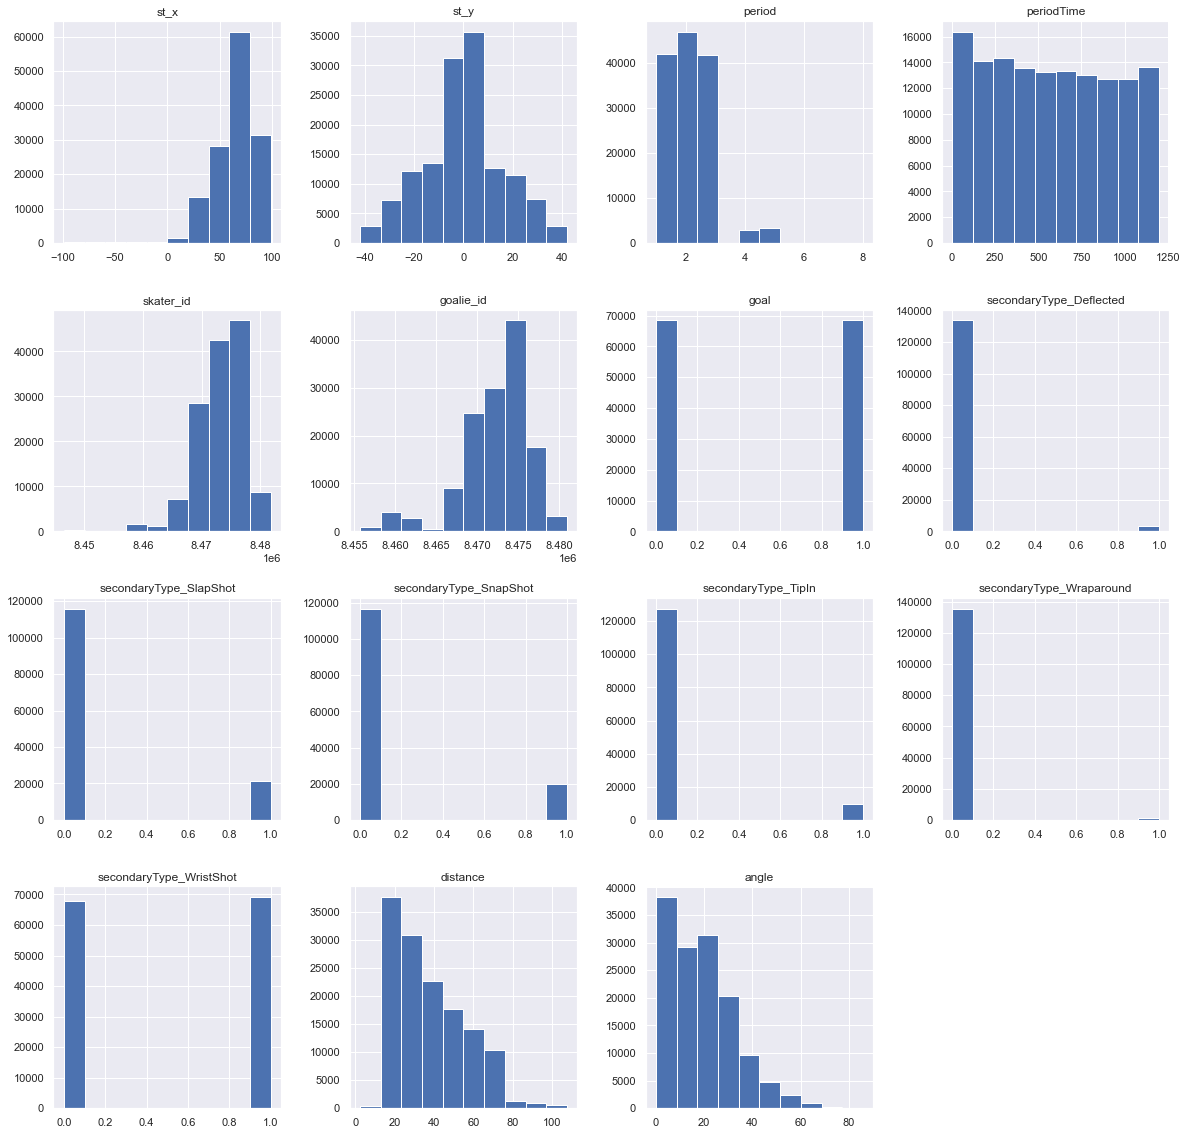

In [13]:
df_data.hist(figsize=(20, 20));

---
Cutting off outliers before moving forward to use the data for modelling

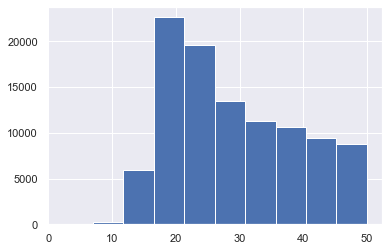

In [14]:
# cutting off outlier in long distance shots
df_data= df_data[df_data.distance<50]
df_data.distance.hist();

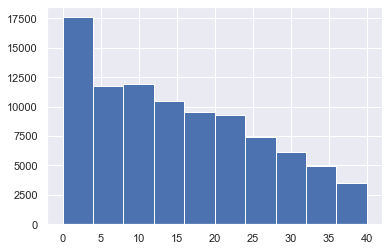

In [15]:
df_data= df_data[df_data.angle<40]
df_data.angle.hist();

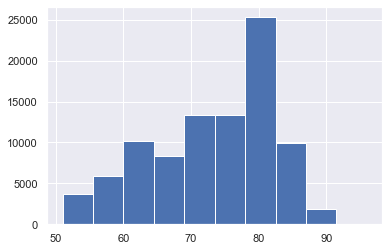

In [16]:
df_data= df_data[df_data.st_x>0]
df_data.st_x.hist();

---
### Using these features in the model.

All candidates for a predictive feature:

In [17]:
df_data.columns

Index(['play_id', 'st_x', 'st_y', 'period', 'periodTime', 'skater_id',
       'goalie_id', 'goal', 'secondaryType_Deflected',
       'secondaryType_SlapShot', 'secondaryType_SnapShot',
       'secondaryType_TipIn', 'secondaryType_Wraparound',
       'secondaryType_WristShot', 'distance', 'angle'],
      dtype='object')

In [18]:
features = df_data.select_dtypes(exclude='object').columns.to_list()
features.remove('goal')

target = 'goal'

lgbm_model = LGBMClassifier(random_state=42);
lgbm_model, X_test, y_test = run_model(lgbm_model, df_data, features, target);

Training duration: 0.31612 seconds
Score of the model is 0.6563
F1-Score of the model is 0.7574


---
This is a huge improvement of the F1 Score performance. 

Let's see how useful the features *skater_id* and *goalie_id* have been for the LGBM classifier. To figure it out, we can use **feature_importance_** property of the model and plot values found in there. Following plots will compare correlation to the target (*goal*) with the importance of particular features:

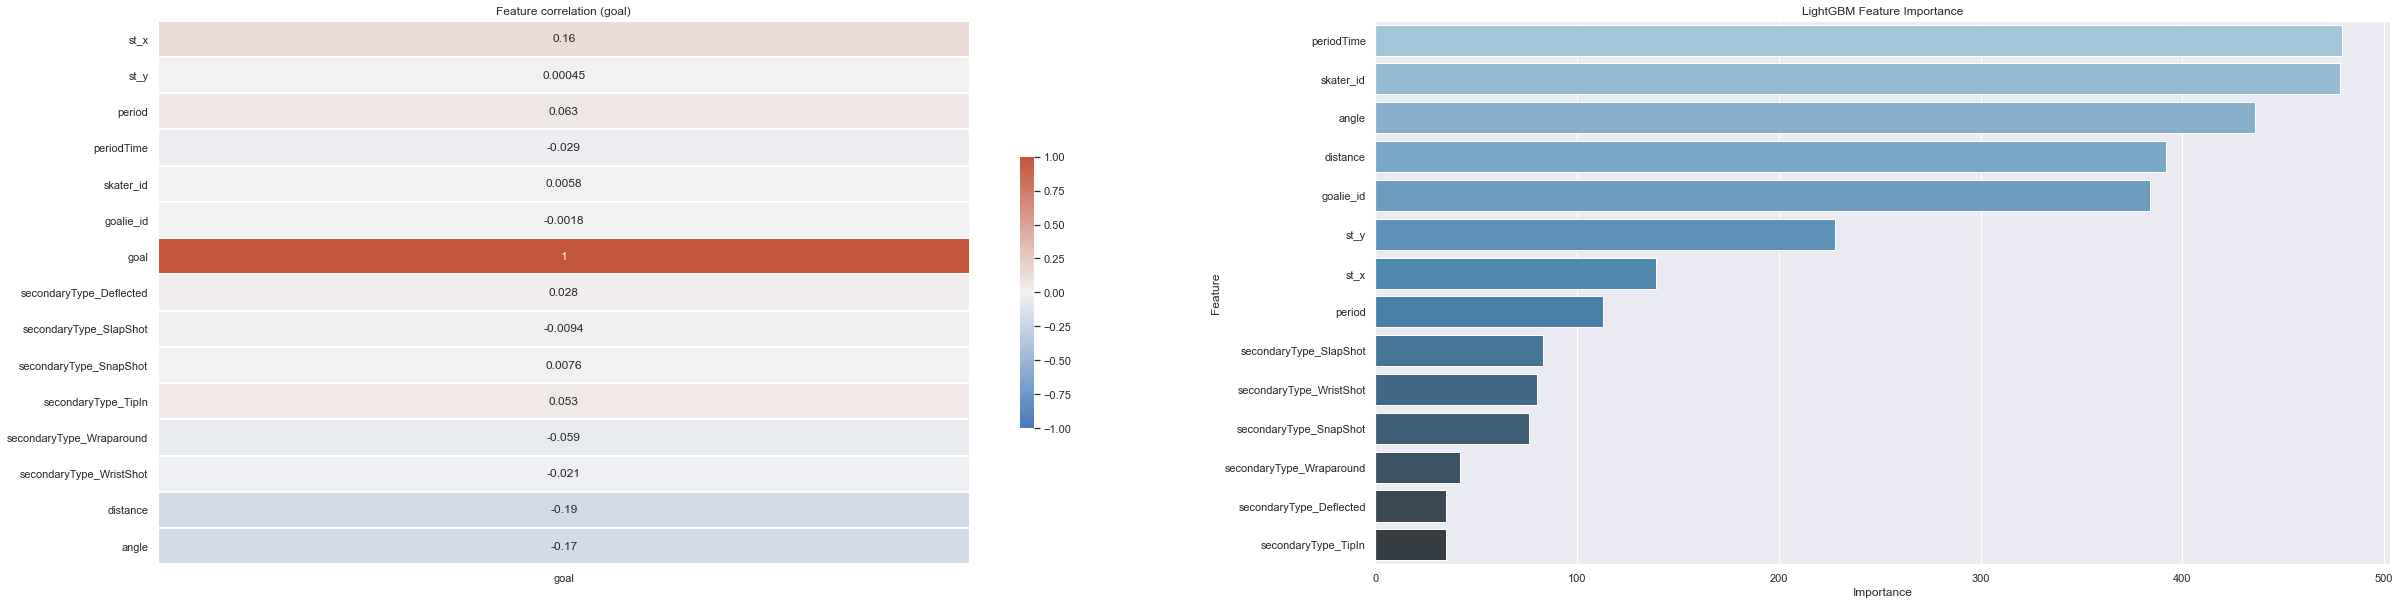

In [19]:
col='goal'
corr = df_data.corr()
cmap = sns.diverging_palette(250, 20, as_cmap=True)

plt.subplots(1, 2, figsize=(40, 10))
plt.subplot(121)

plt.title('Feature correlation (goal)')
sns.heatmap(corr[[col]], cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, linewidths=1, cbar_kws={"shrink": .5});

plt.subplot(122)
feature_imp = pd.DataFrame({'Importance':lgbm_model.feature_importances_,'Feature':features})
sns.barplot(x="Importance", y="Feature", palette='Blues_d', data=feature_imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Feature Importance')
plt.show()

As we can see in the plots, the correlation itself is not always the same like the importance for the model. The most important features (right plot) for the goal prediction are *skater_id* and *distance* (which totaly makes sense). In the correlation plot (left plot), the *distance* is strongly correlated with *goal* but *skater_id* is not.

---

## Adding more features realated to players

*skater_id* and *goalie_id* are pretty promissing features. Let's add some more details of players:
* Salary
* Player statistics
* Goalie save percentage

---
Looking at the data first

In [20]:
df_player_info = pd.read_csv('data/nhl/nhl_stats/player_info.csv')
df_player_info.head()

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R


---
Calculating overall savePercentage for each goalie:

In [21]:
df_goalie = pd.read_csv('data/nhl/nhl_stats/game_goalie_stats.csv')
df_goalie = df_goalie.groupby('player_id').agg({'savePercentage':'mean'}).reset_index()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)
df_goalie.head()                                      

,goalie_id,savePercentage
0,8445275,89.979639
1,8445386,89.914678
2,8445470,86.247964
3,8445769,90.347714
4,8446719,87.575872


---
Calculating overall statistics for each skater:

In [22]:
df_skater = pd.read_csv('data/nhl/nhl_stats/game_skater_stats.csv')
df_skater = df_skater.groupby('player_id').agg({'goals':'sum', 'shots':'sum', 'assists':'sum', 'timeOnIce':'sum'}).reset_index()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)
df_skater.head()

,skater_id,goals,shots,assists,timeOnIce
0,8444894,11,66,12,51806
1,8444919,4,174,37,232930
2,8445000,88,696,74,322029
3,8445176,59,532,82,214915
4,8445266,7,185,23,329428


---
Merging it together in the training dataset

In [23]:
df_merged = df_data.copy()

df_merged = df_merged.merge(df_skater, how='left', on='skater_id')
df_merged = df_merged.merge(df_goalie, how='left', on='goalie_id')

df_merged.head()

,play_id,st_x,st_y,period,periodTime,skater_id,goalie_id,goal,secondaryType_Deflected,secondaryType_SlapShot,...,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot,distance,angle,goals,shots,assists,timeOnIce,savePercentage
0,2016020045_6,88.0,-5.0,1,56,8474141.0,8473607.0,1,0,0,...,0,1,0,13.000000,22.619865,505,4185,815,1510638,90.093364
1,2016020045_97,76.0,-1.0,1,1046,8477929.0,8473607.0,1,0,0,...,0,0,0,24.020824,2.385944,10,143,12,89325,90.093364
2,2016020045_140,83.0,-11.0,2,304,8466148.0,8473607.0,1,0,0,...,0,0,0,20.248457,32.905243,499,4143,606,1429420,90.093364
3,2016020045_197,76.0,11.0,2,1103,8476177.0,8470645.0,1,0,0,...,0,0,1,26.400758,24.623565,94,809,105,476023,91.021338
4,2016020045_214,79.0,2.0,3,37,8476177.0,8470645.0,1,0,0,...,0,0,1,21.095023,5.440332,94,809,105,476023,91.021338


---
#### Adding salary

---
Read dataset with salary information:

In [24]:
df_players_train = pd.read_csv('data/nhl/nhl_salaries/train.csv')
df_players_test = pd.read_csv('data/nhl/nhl_salaries/test.csv')

df_player_stats = pd.concat([df_players_train, df_players_test])
df_player_stats.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.0,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000.0,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000.0,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000.0,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000.0,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [25]:
df_player_stats = df_player_stats[['First Name', 'Last Name', 'Nat', 'Salary']].rename(columns={'First Name':'firstName', 'Last Name':'lastName', 'Nat':'nationality', 'Salary':'salary'})
df_player_stats.head()

,firstName,lastName,nationality,salary
0,Thomas,Chabot,CAN,925000.0
1,Cody,Ceci,CAN,2250000.0
2,Kyle,Okposo,USA,8000000.0
3,Erik,Gudbranson,CAN,3500000.0
4,Tom,Wilson,CAN,1750000.0


---
Prepare player_info for merging

In [26]:
df_player_info.rename(columns={'player_id':'skater_id'}, inplace=True)
df_player_info.head()

,skater_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R


---
Merge player info to get additional identification data for the player: 

In [27]:
#add name and nationality of the skater
df_merged = df_merged.merge(df_player_info[['skater_id', 'firstName', 'lastName', 'nationality']], how='left', on='skater_id')
df_merged.head()

,play_id,st_x,st_y,period,periodTime,skater_id,goalie_id,goal,secondaryType_Deflected,secondaryType_SlapShot,...,distance,angle,goals,shots,assists,timeOnIce,savePercentage,firstName,lastName,nationality
0,2016020045_6,88.0,-5.0,1,56,8474141.0,8473607.0,1,0,0,...,13.000000,22.619865,505,4185,815,1510638,90.093364,Patrick,Kane,USA
1,2016020045_97,76.0,-1.0,1,1046,8477929.0,8473607.0,1,0,0,...,24.020824,2.385944,10,143,12,89325,90.093364,Dennis,Rasmussen,SWE
2,2016020045_140,83.0,-11.0,2,304,8466148.0,8473607.0,1,0,0,...,20.248457,32.905243,499,4143,606,1429420,90.093364,Marian,Hossa,SVK
3,2016020045_197,76.0,11.0,2,1103,8476177.0,8470645.0,1,0,0,...,26.400758,24.623565,94,809,105,476023,91.021338,Matt,Read,CAN
4,2016020045_214,79.0,2.0,3,37,8476177.0,8470645.0,1,0,0,...,21.095023,5.440332,94,809,105,476023,91.021338,Matt,Read,CAN


---
Add salary to the merged dataset:

In [28]:
# add salary
df_merged = df_merged.merge(df_player_stats, how='left', on=['firstName', 'lastName', 'nationality'])
df_merged.head()

,play_id,st_x,st_y,period,periodTime,skater_id,goalie_id,goal,secondaryType_Deflected,secondaryType_SlapShot,...,angle,goals,shots,assists,timeOnIce,savePercentage,firstName,lastName,nationality,salary
0,2016020045_6,88.0,-5.0,1,56,8474141.0,8473607.0,1,0,0,...,22.619865,505,4185,815,1510638,90.093364,Patrick,Kane,USA,13800000.0
1,2016020045_97,76.0,-1.0,1,1046,8477929.0,8473607.0,1,0,0,...,2.385944,10,143,12,89325,90.093364,Dennis,Rasmussen,SWE,575000.0
2,2016020045_140,83.0,-11.0,2,304,8466148.0,8473607.0,1,0,0,...,32.905243,499,4143,606,1429420,90.093364,Marian,Hossa,SVK,4000000.0
3,2016020045_197,76.0,11.0,2,1103,8476177.0,8470645.0,1,0,0,...,24.623565,94,809,105,476023,91.021338,Matt,Read,CAN,4000000.0
4,2016020045_214,79.0,2.0,3,37,8476177.0,8470645.0,1,0,0,...,5.440332,94,809,105,476023,91.021338,Matt,Read,CAN,4000000.0


___
Replace missing salary with median (to ignore outliers):

In [29]:
# replace missing salary
df_merged.salary.fillna(df_merged.salary.median(), inplace=True)
df_merged.head()

,play_id,st_x,st_y,period,periodTime,skater_id,goalie_id,goal,secondaryType_Deflected,secondaryType_SlapShot,...,angle,goals,shots,assists,timeOnIce,savePercentage,firstName,lastName,nationality,salary
0,2016020045_6,88.0,-5.0,1,56,8474141.0,8473607.0,1,0,0,...,22.619865,505,4185,815,1510638,90.093364,Patrick,Kane,USA,13800000.0
1,2016020045_97,76.0,-1.0,1,1046,8477929.0,8473607.0,1,0,0,...,2.385944,10,143,12,89325,90.093364,Dennis,Rasmussen,SWE,575000.0
2,2016020045_140,83.0,-11.0,2,304,8466148.0,8473607.0,1,0,0,...,32.905243,499,4143,606,1429420,90.093364,Marian,Hossa,SVK,4000000.0
3,2016020045_197,76.0,11.0,2,1103,8476177.0,8470645.0,1,0,0,...,24.623565,94,809,105,476023,91.021338,Matt,Read,CAN,4000000.0
4,2016020045_214,79.0,2.0,3,37,8476177.0,8470645.0,1,0,0,...,5.440332,94,809,105,476023,91.021338,Matt,Read,CAN,4000000.0


---
As we can see, there are new features for skater making the shot (goals, shots, assists, time on ice, salary) and for the goaling catching it (save percentage)

---

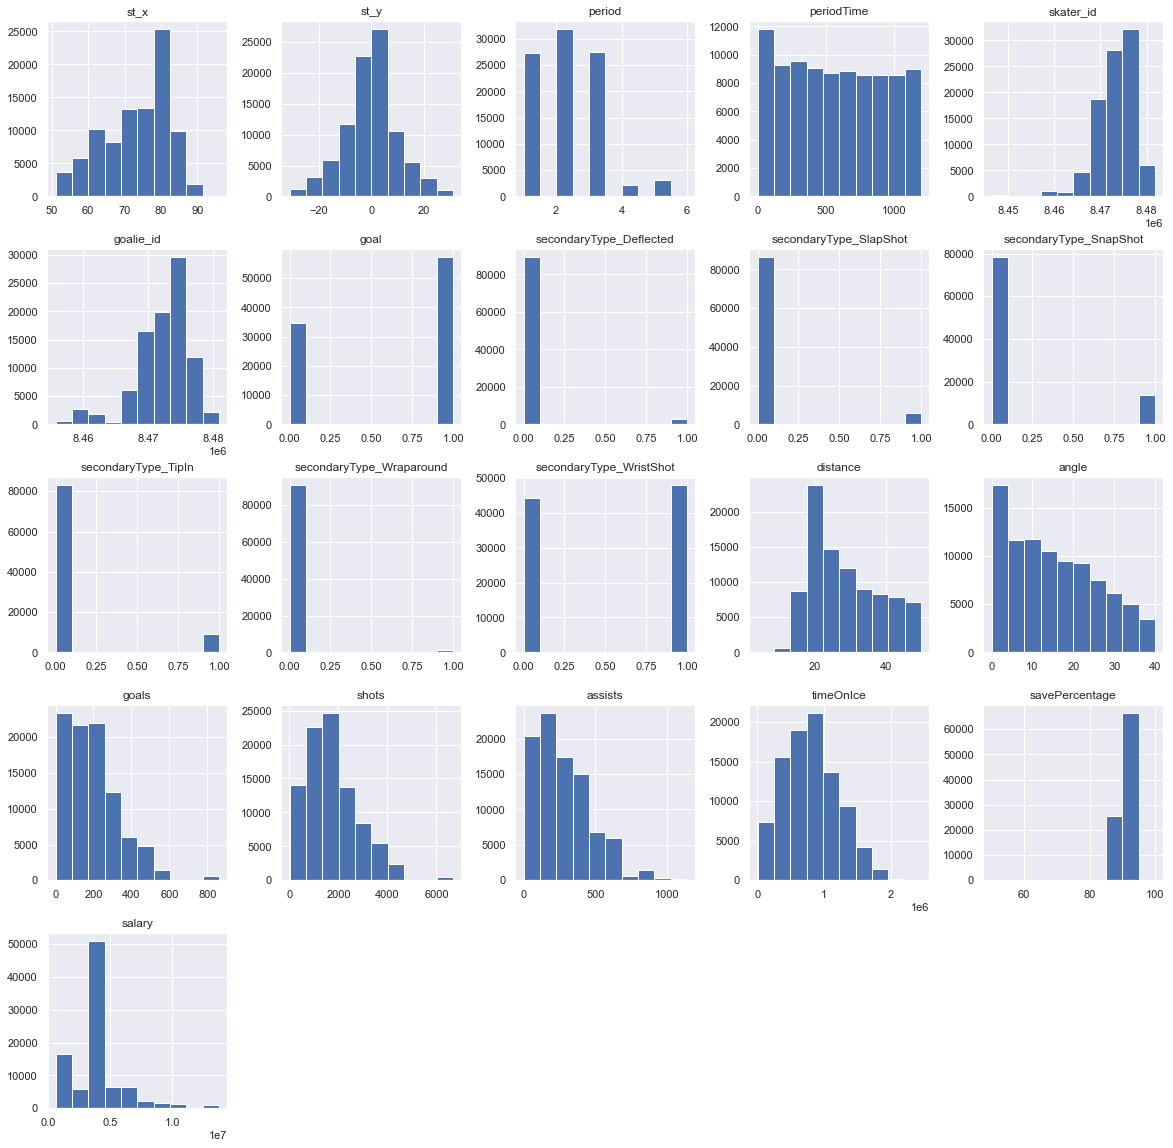

In [30]:
df_merged.hist(figsize=(20, 20));

In [31]:
df_merged = df_merged[df_merged.goals<400]
df_merged = df_merged[df_merged.shots<4000]
df_merged = df_merged[df_merged.assists<700]
df_merged = df_merged[df_merged.salary<10000000]

In [32]:
features = df_data.select_dtypes(exclude='object').columns.to_list()
features.remove('goal')

target = 'goal'

lgbm_model = LGBMClassifier(random_state=42);
lgbm_model, X_test, y_test = run_model(lgbm_model, df_merged, features, target);

Training duration: 0.29443 seconds
Score of the model is 0.6557
F1-Score of the model is 0.7561


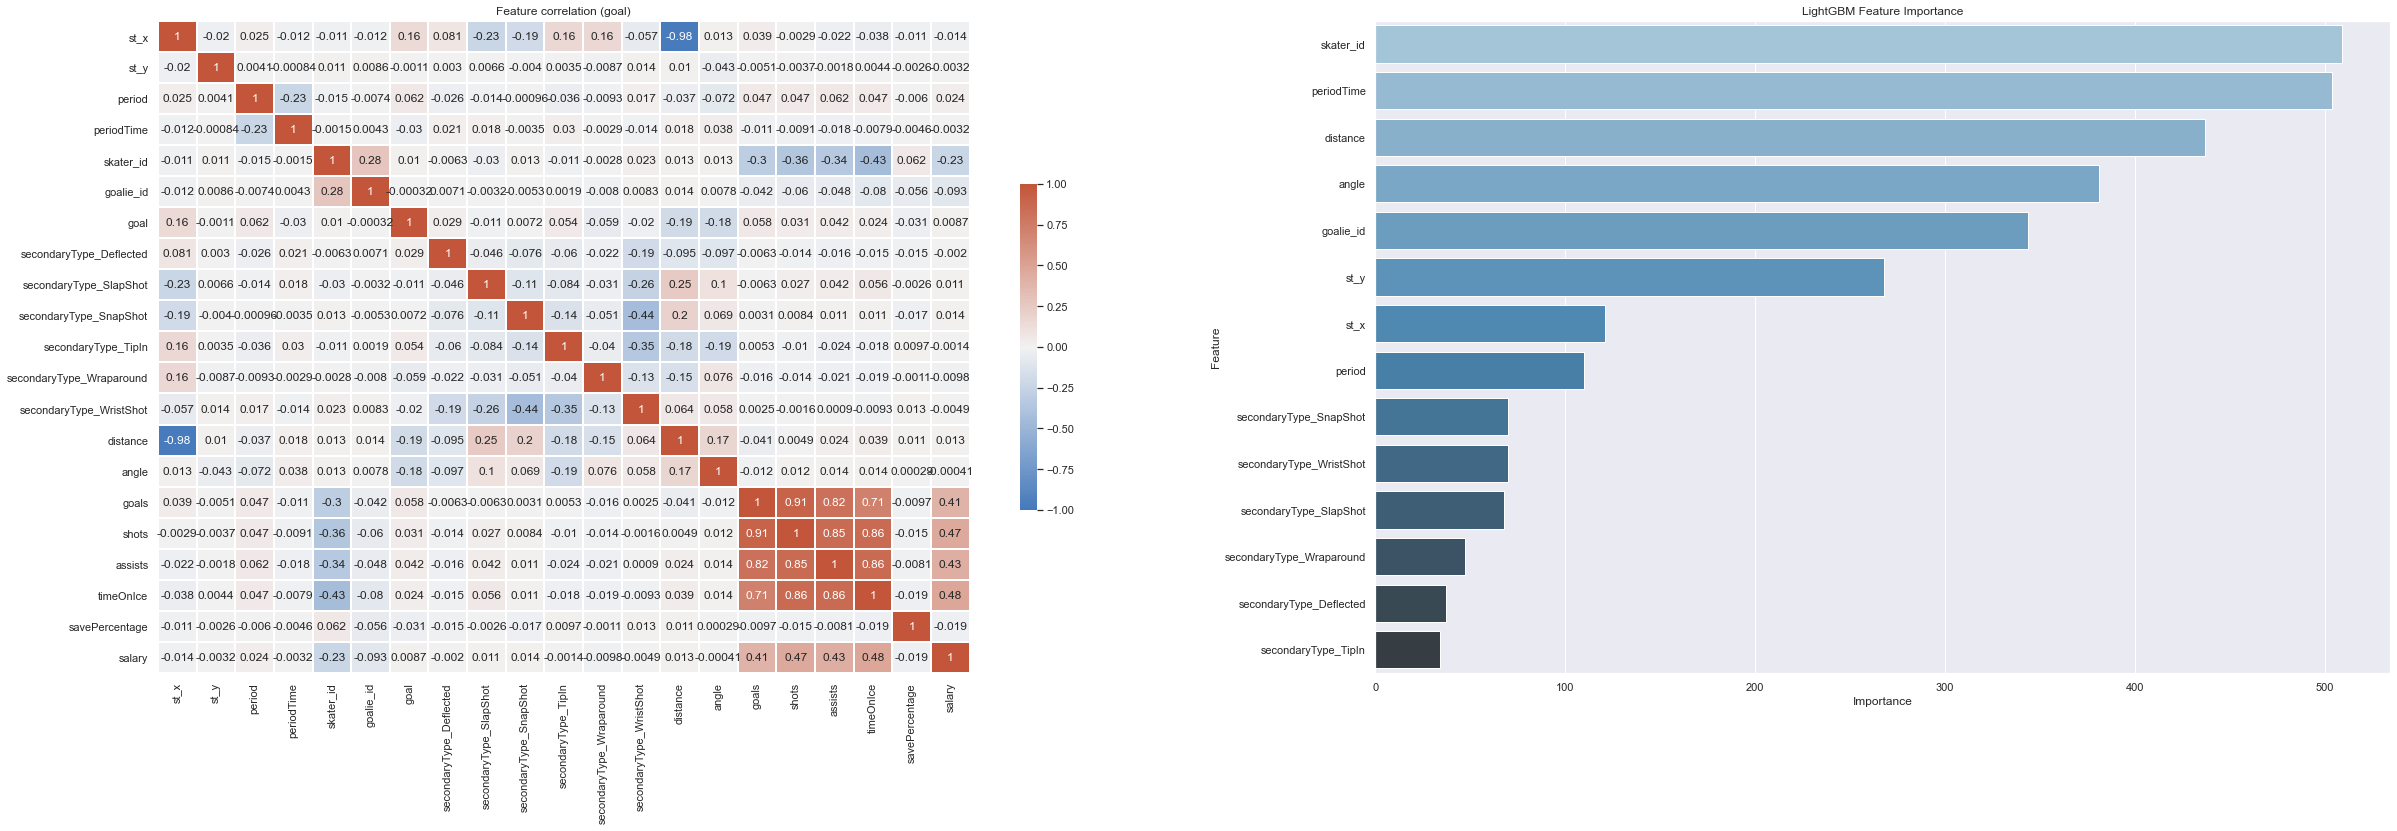

In [33]:
col='goal'
corr = df_merged.corr()
cmap = sns.diverging_palette(250, 20, as_cmap=True)

plt.subplots(1, 2, figsize=(40, 12))
plt.subplot(121)

plt.title('Feature correlation (goal)')
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, linewidths=1, cbar_kws={"shrink": .5});

plt.subplot(122)
feature_imp = pd.DataFrame({'Importance':lgbm_model.feature_importances_,'Feature':features})
sns.barplot(x="Importance", y="Feature", palette='Blues_d', data=feature_imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Feature Importance')
plt.show()

#### Conlusion on feature engineering for players data:
After adding of detailed information about players, there was no improvement of the F1 Score at all. The reason is, that *skater_id*, which is the most important feature for the model, is strongly correlated to all this detailed data. It' a kind of representation of it. That's also the reason why the LightGBM completely dropped almost all the features considering them as non relevat. Note on the right plot, that features goals, shots, assists, timeOnIce and salary and not in the list of important features at all. The model can chosen its features.

---

## Short vs. long distance shots

After all the feature engineering, let's see how is this model predisting on short vs. long distance shots. We split the dataset to two:

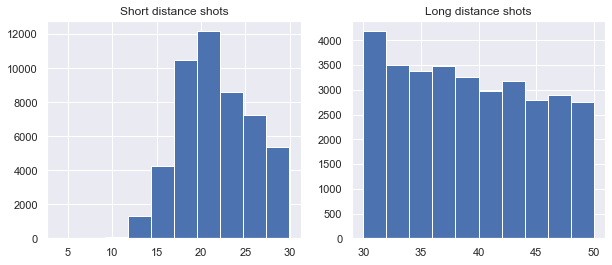

In [34]:
df_short_dist = df_merged[df_merged.distance<30]
df_long_dist = df_merged[df_merged.distance>=30]

plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(121)
df_short_dist.distance.hist();
plt.title('Short distance shots');
plt.subplot(122)
df_long_dist.distance.hist();
plt.title('Long distance shots');

---
Plotting locations of the short distance shots:

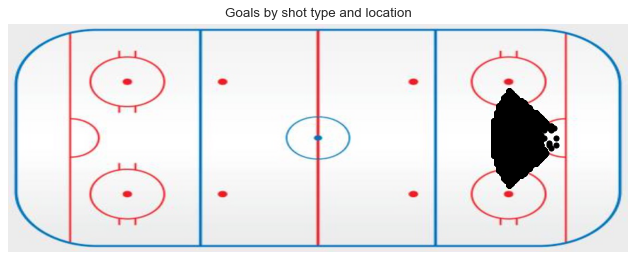

In [35]:
plt.figure(figsize=(10, 6), dpi=80)
img=plt.imread('data/images/rink.jpg')
plt.grid()
plt.axis("off")
plt.imshow(img, extent=[-125, 125, -46, 46])
plt.scatter(df_short_dist.st_x, df_short_dist.st_y, s=20, c='black');
plt.title('Goals by shot type and location');

---
Plotting locations of the long distance shots:

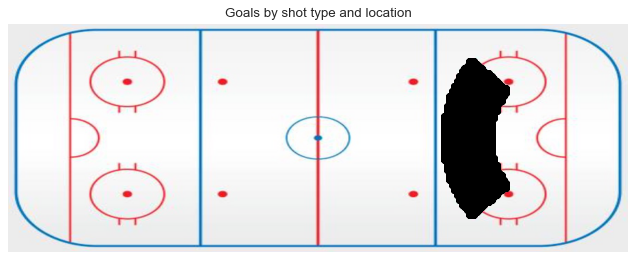

In [36]:
plt.figure(figsize=(10, 6), dpi=80)
img=plt.imread('data/images/rink.jpg')
plt.grid()
plt.axis("off")
plt.imshow(img, extent=[-125, 125, -46, 46])
plt.scatter(df_long_dist.st_x, df_long_dist.st_y, s=20, c='black');
plt.title('Goals by shot type and location');

---
Predicting goals for both this groups:

In [37]:
features = df_short_dist.select_dtypes(exclude='object').columns.to_list()
features.remove('goal')

target = 'goal'

lgbm_model = LGBMClassifier(random_state=42);
lgbm_model, X_test, y_test = run_model(lgbm_model, df_short_dist, features, target);

Training duration: 0.20230 seconds
Score of the model is 0.6939
F1-Score of the model is 0.8085


In [38]:
features = df_long_dist.select_dtypes(exclude='object').columns.to_list()
features.remove('goal')

target = 'goal'

lgbm_model = LGBMClassifier(random_state=42);
lgbm_model, X_test, y_test = run_model(lgbm_model, df_long_dist, features, target);

Training duration: 0.18096 seconds
Score of the model is 0.6080
F1-Score of the model is 0.6441


---
### Conclusion on the short vs. long distance shots prediction: 
There is a huge difference between F1 score for predicting the goal probability for short distance vs. long distance shots. It looks like short distance goals are easier to predict. Those are apparently more dependent on featues recognized as important. On the other hand, the long distance goal do always include a **bit of luck**.


---
---

# Model finetuning

In [39]:
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

---
Using grid search cross validation, some values of grid parameters will be picked and model will be trained repeatedly to find the best set of parameter. The scoring will be done with the best combination.

In [40]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_merged[features], df_merged[target], test_size=0.3, random_state=42)


params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
          'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
          'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
          'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
          'min_split_gain': 0.5, 'min_child_weight': 1, 
          'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
          'metric': 'binary_error'}

grid_params = {'boosting_type': ['gbdt'], 
          'colsample_bytree': [0.75, 0.8, 0.85], 
          'learning_rate': [0.05, 0.1, 0.15], 
          'max_depth': [4, 5, 6], 
          'n_estimators': [80, 100, 120], 
          'num_leaves': [12, 18, 24], 
          'objective': ['binary'], 
          'reg_alpha': [4, 5, 6], 
          'reg_lambda': [4, 5, 6], 
          'seed': [500, 600, 700], 
          'subsample': [0.75]}

model = LGBMClassifier(**params);
grid = GridSearchCV(model, param_grid=grid_params, verbose=1, cv=5, n_jobs=-1)

# start trainig
start = time.time()
print(f'Starting...')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)


#model.fit(X_train,y_train)
duration = time.time() - start
print(f'Training ran in {duration:.5f} seconds')    

# use model score
score = grid.score(X_test, y_test)    
print(f'Score: {score}')

#calculate f1 score
f1 = f1_score(y_test, grid.predict(X_test))
print(f'F1 Score: {f1:.4f}')

Starting...
Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 80, 'num_leaves': 18, 'objective': 'binary', 'reg_alpha': 4, 'reg_lambda': 5, 'seed': 700, 'subsample': 0.75}
0.6588956280156545
Training ran in 2396.98740 seconds
Score: 0.6594548343723261
F1 Score: 0.7591


-------------------

## Conclusion:
The F1 score has been slightly increased again. We still could try additional parameter combinations and re-run the cross validation again and again. We would probably increase the F1 score value a bit but at the end of the day, it's sometimes not possible to achieve 100% fit of the model with given a dataset at all. There still might be other features playing an important role in the fact, if a shot lands in the goal or not. And these features are possibly not a part of the dataset. This fact plus a bit of luck in each shot makes the hockey game that exciting.

------

I defined metrics to measure performance of the model, which was F1 score. I explained how to calculate this metrics based on a confusion matrix and why it is better than just score. I visualized predicted sigmoid function and showed how the data fits the curve. I started with the first version of the model having F1-score=**0.65**. Using feature engineering, classifier selection and fine tuning, I was able to increase F1-score to **0.76**. For short distance shots it was even **0.81**, which is really great. I measured evetything, visualized all my findings and figured out, what features are the most important once to predict a goal.

There was a lot discussed regarding the model performance evaluation in previous section. Metrics were explained, calculated and visualized after ever attempt to improve the model. What worked very good was selecting of proper data, defining features but also selecting a proper classifier. The selected LightGBM classifier was not just performing well but also very fast. It was also able to explain what features are important to provide the prediction. All this was explained and visualized in previous sections.

One of the most interesting parts in the model improvement for the feature selection. Mutual strongly correlated have been simply ignored by the classifier and just one representative of them have been used. Another interesting aspect was the behaviour of the model with biased target. It tended to predict with high score but very low F1 score predicting all shots as no-goal. At this moment, the model could habe been replaced by a function with one statement *return 0;* and the same result would have come.   

The F1 Score is still not 1.0 but this value migh not be achievable at all. Besides all data in the dataset, there still can be other factors having impact on the goal/no-goal result. Defending players and their actions? Ice temperature? Noise in the stadium? All those might be the missing peace of the mosaic. 

For all other details and additional thoughts and explanations, please see text fields in notebooks.
